# Variant-effect prediction evaluation

## Setup

In [1]:
import os
import yaml
import pathlib
import polars as pl
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score
import plotnine as pn
import pandas as pd
from rep.utils import get_prc_curve_df
import warnings
from scipy.stats import ranksums
import seaborn as sns
import numpy as np
import scipy
from sklearn.metrics import r2_score
import traceback

In [2]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [4]:
def setup_dev(run_key):
    # Set working directory
    root_dir='../../'
    os.chdir(root_dir)
    
    # Read configuration files
    config_files = ['config/components.dev.yaml',
                    'config/main.dev.yaml']
    config = dict()
    for f in config_files:
        with open(f) as stream:
            config.update(yaml.safe_load(stream))
            
    # Set default wildcards
    wildcards = dict(run_key=run_key)

    # Set input files
    input_ = {
        'benchmark_path' : pathlib.Path(config["output_path"]) / 'benchmark.parquet' / f'run={run_key}/data.parquet'
    }

    # supress warnings
    warnings.filterwarnings('ignore', category=UserWarning, append=True)

    # Set output files
    evaluation_path = pathlib.Path(config["output_path"]) / 'evaluation'
    output = dict(
        prc_path = evaluation_path / 'prc.parquet' / f'run={run_key}/data.parquet',
        prc_tissue_path = evaluation_path / 'prc_tissue.parquet' / f'run={run_key}/data.parquet',
        prc_tissue_type_path = evaluation_path / 'prc_tissue_type.parquet' / f'run={run_key}/data.parquet',
        prc_fold_path = evaluation_path / 'prc_fold.parquet' / f'run={run_key}/data.parquet',
        r2_path = evaluation_path / 'r2.parquet' / f'run={run_key}/data.parquet',
        r2_tissue_path = evaluation_path / 'r2_tissue.parquet' / f'run={run_key}/data.parquet',
        r2_tissue_type_path = evaluation_path / 'r2_tissue_type.parquet' / f'run={run_key}/data.parquet',
        r2_fold_path = evaluation_path / 'r2_fold.parquet' / f'run={run_key}/data.parquet',
    )
    for f in output.values():
        f.parent.mkdir(parents=True, exist_ok=True)
    
    return wildcards, config, input_, output

In [5]:
try:
    snakemake
    wildcards = snakemake.wildcards
    config = snakemake.config
    input_ = snakemake.input
    output = snakemake.output
except NameError:
    # Setup development environment if no snakemake variable is found
    wildcards, config, input_, output = setup_dev(run_key='enformer_veff1')

##  Analysis

In [6]:
wildcards

{'run_key': 'enformer_veff1'}

In [7]:
# read benchmark file
benchmark_path = input_['benchmark_path']
benchmark_df = pl.read_parquet(benchmark_path, hive_partitioning=False)
benchmark_df = benchmark_df.with_columns((pl.col('outlier_state') == 'underexpressed').alias('y_true'))
benchmark_df = benchmark_df.with_columns((-pl.col('veff_score')).alias('y_pred'))

In [8]:
def pretty_mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f'{m:.5f} +- {h:.5f}'

In [9]:
def calc_prc_df(
    df,
    groupby=None,
    true_col="y_true",
    pred_col="y_pred",
    round_decimals=4
):
    if groupby is None:
        prc_df = get_prc_curve_df(
            y_trues=[df[true_col]],
            y_preds=[df[pred_col]],
            labels=["model"],
            binary_as_point=True
        ).drop(columns="model")
    else:
        true = []
        pred = []
        models = []
        for idx, group in df.groupby(groupby):
            true.append(group[true_col])
            pred.append(group[pred_col])
            models.append(idx)

        prc_df = get_prc_curve_df(
            y_trues=true,
            y_preds=pred,
            labels=models,
            binary_as_point=True
        ).rename(columns={"model": groupby})

        
    if round_decimals is not None:
        prc_df["recall"] = prc_df["recall"].round(decimals=round_decimals)
        prc_df["precision"] = prc_df["precision"].round(decimals=round_decimals)

    compare_drop_cols = ["threshold", "auc"]
    prc_df = prc_df[
        prc_df.drop(columns=compare_drop_cols)
        .ne(
            # shift by 1
            prc_df.drop(columns=compare_drop_cols).shift()
        )
        .any(axis=1)
    ]
    
    return (prc_df)

### All tissues

In [10]:
pred_df = benchmark_df
r2_total = r2_score(pred_df["zscore"], pred_df["veff_score"])

obvious_pred_df = benchmark_df.filter(pl.col('is_obvious_outlier'))
r2_obv = r2_score(obvious_pred_df["zscore"], obvious_pred_df["veff_score"])

not_obvious_pred_df = benchmark_df.filter(~pl.col('is_obvious_outlier'))
r2_notobv = r2_score(not_obvious_pred_df["zscore"], not_obvious_pred_df["veff_score"])

res = pd.DataFrame(dict(type_=['total', 'obvious', 'not_obvious'], r2=[r2_total, r2_obv, r2_notobv],
                       nsamples=[len(pred_df), len(obvious_pred_df), len(not_obvious_pred_df)],
                       num_y_true=[pred_df.select(pl.col('y_true').sum()).item(), 
                                   obvious_pred_df.select(pl.col('y_true').sum()).item(),
                                   not_obvious_pred_df.select(pl.col('y_true').sum()).item()]))
res = res.assign(enrichment=res.num_y_true/res.nsamples)
res.to_parquet(output['r2_path'])
del pred_df, obvious_pred_df, not_obvious_pred_df
res

,type_,r2,nsamples,num_y_true,enrichment
0,total,-0.000254,426471,61,0.000143
1,obvious,-0.115356,312,16,0.051282
2,not_obvious,-0.000255,426159,45,0.000106


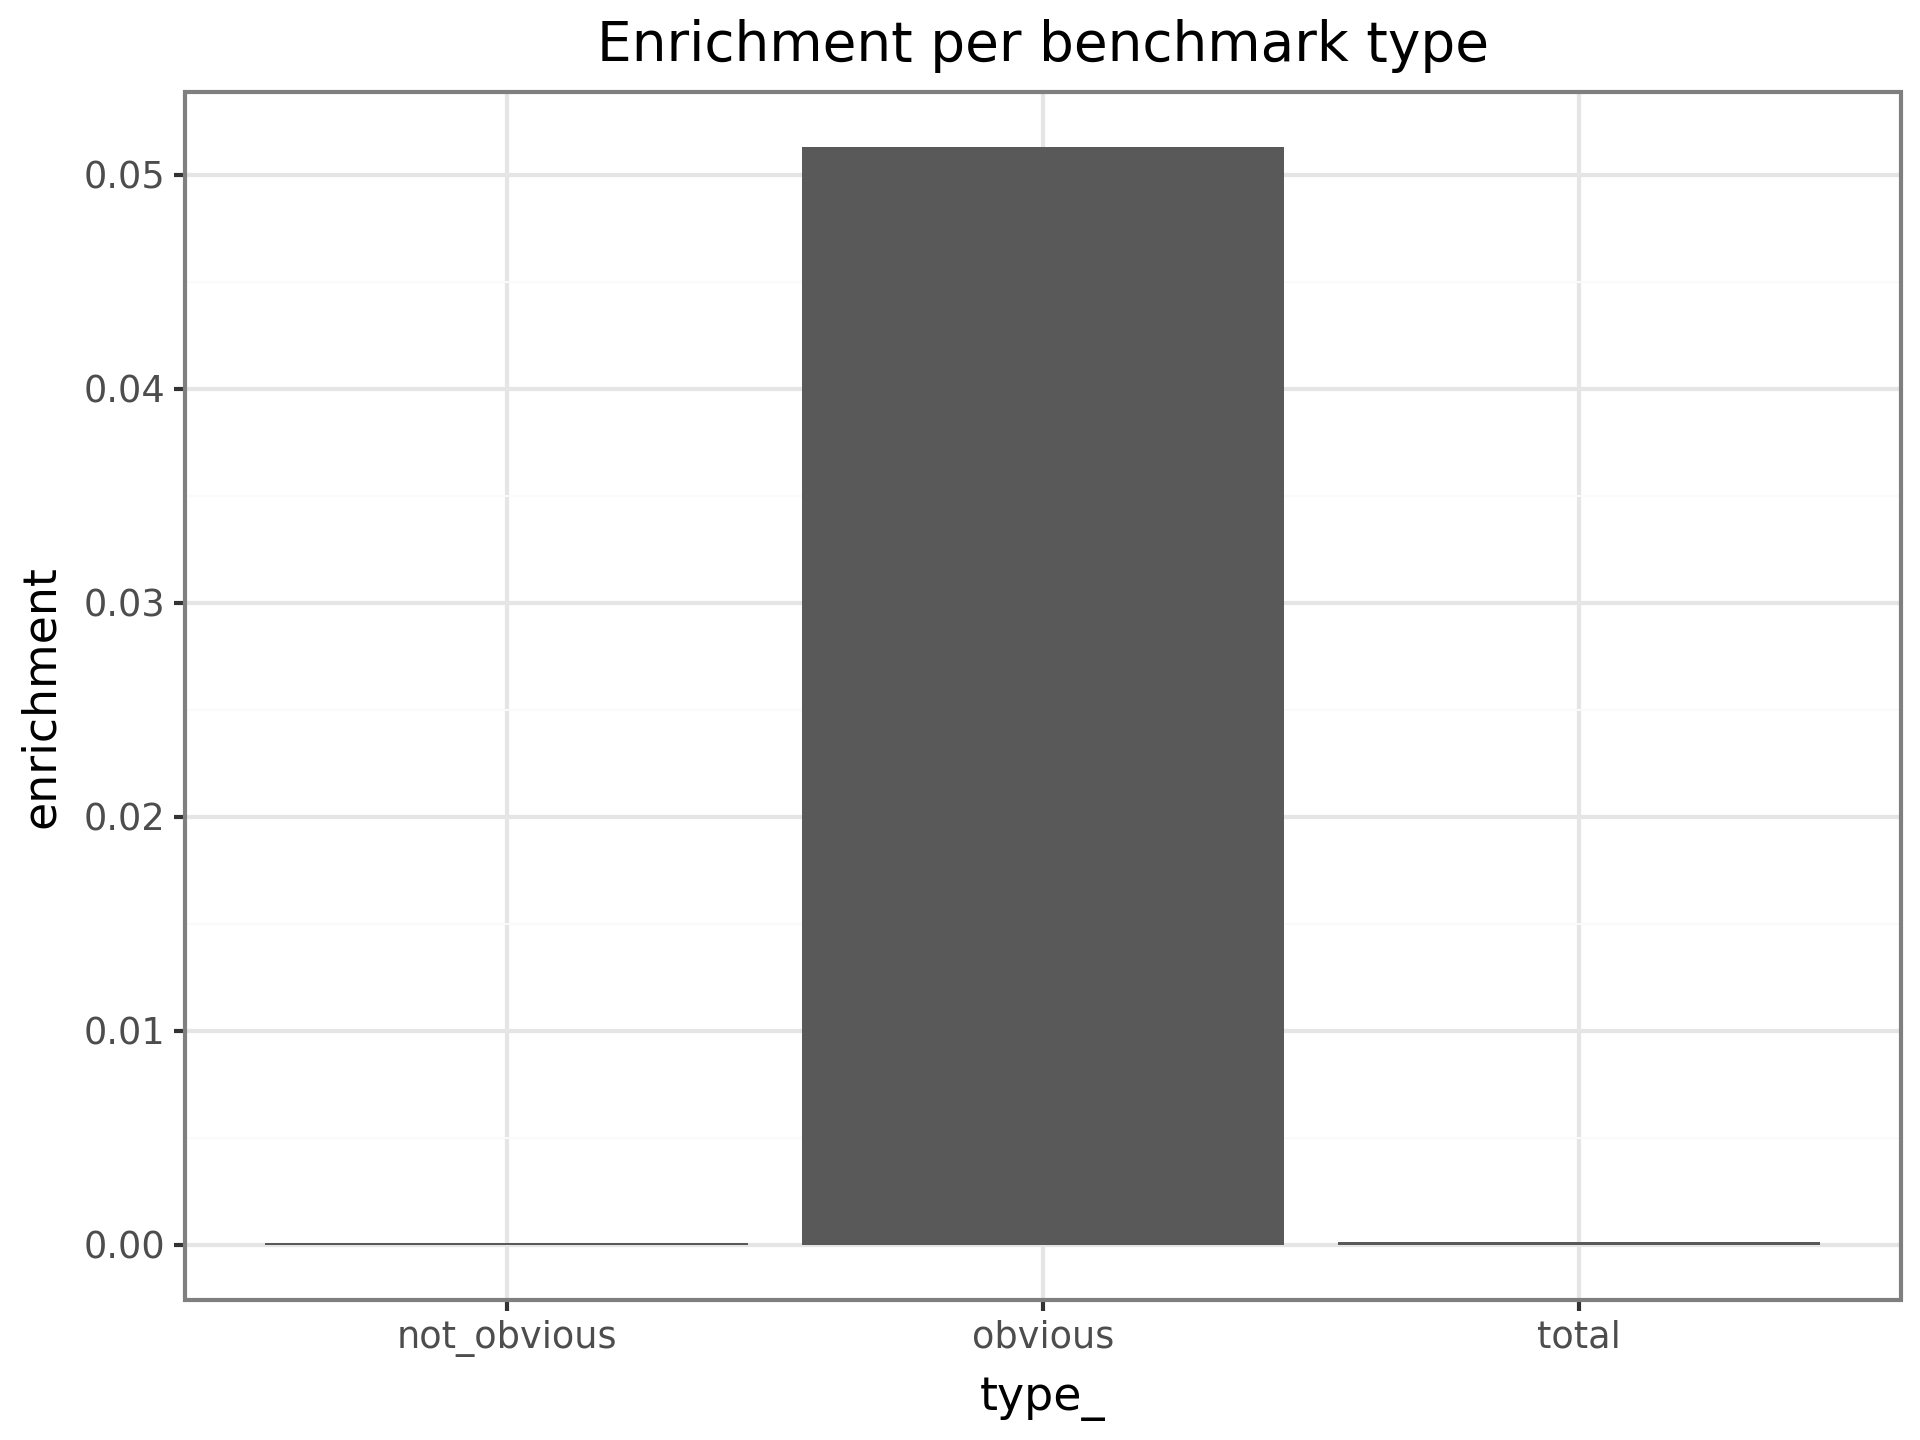

In [11]:
pn.ggplot(res, pn.aes(x='type_', y='enrichment')) + pn.geom_bar(stat='identity') + \
    pn.labs(title='Enrichment per benchmark type') + pn.scale_y_continuous()

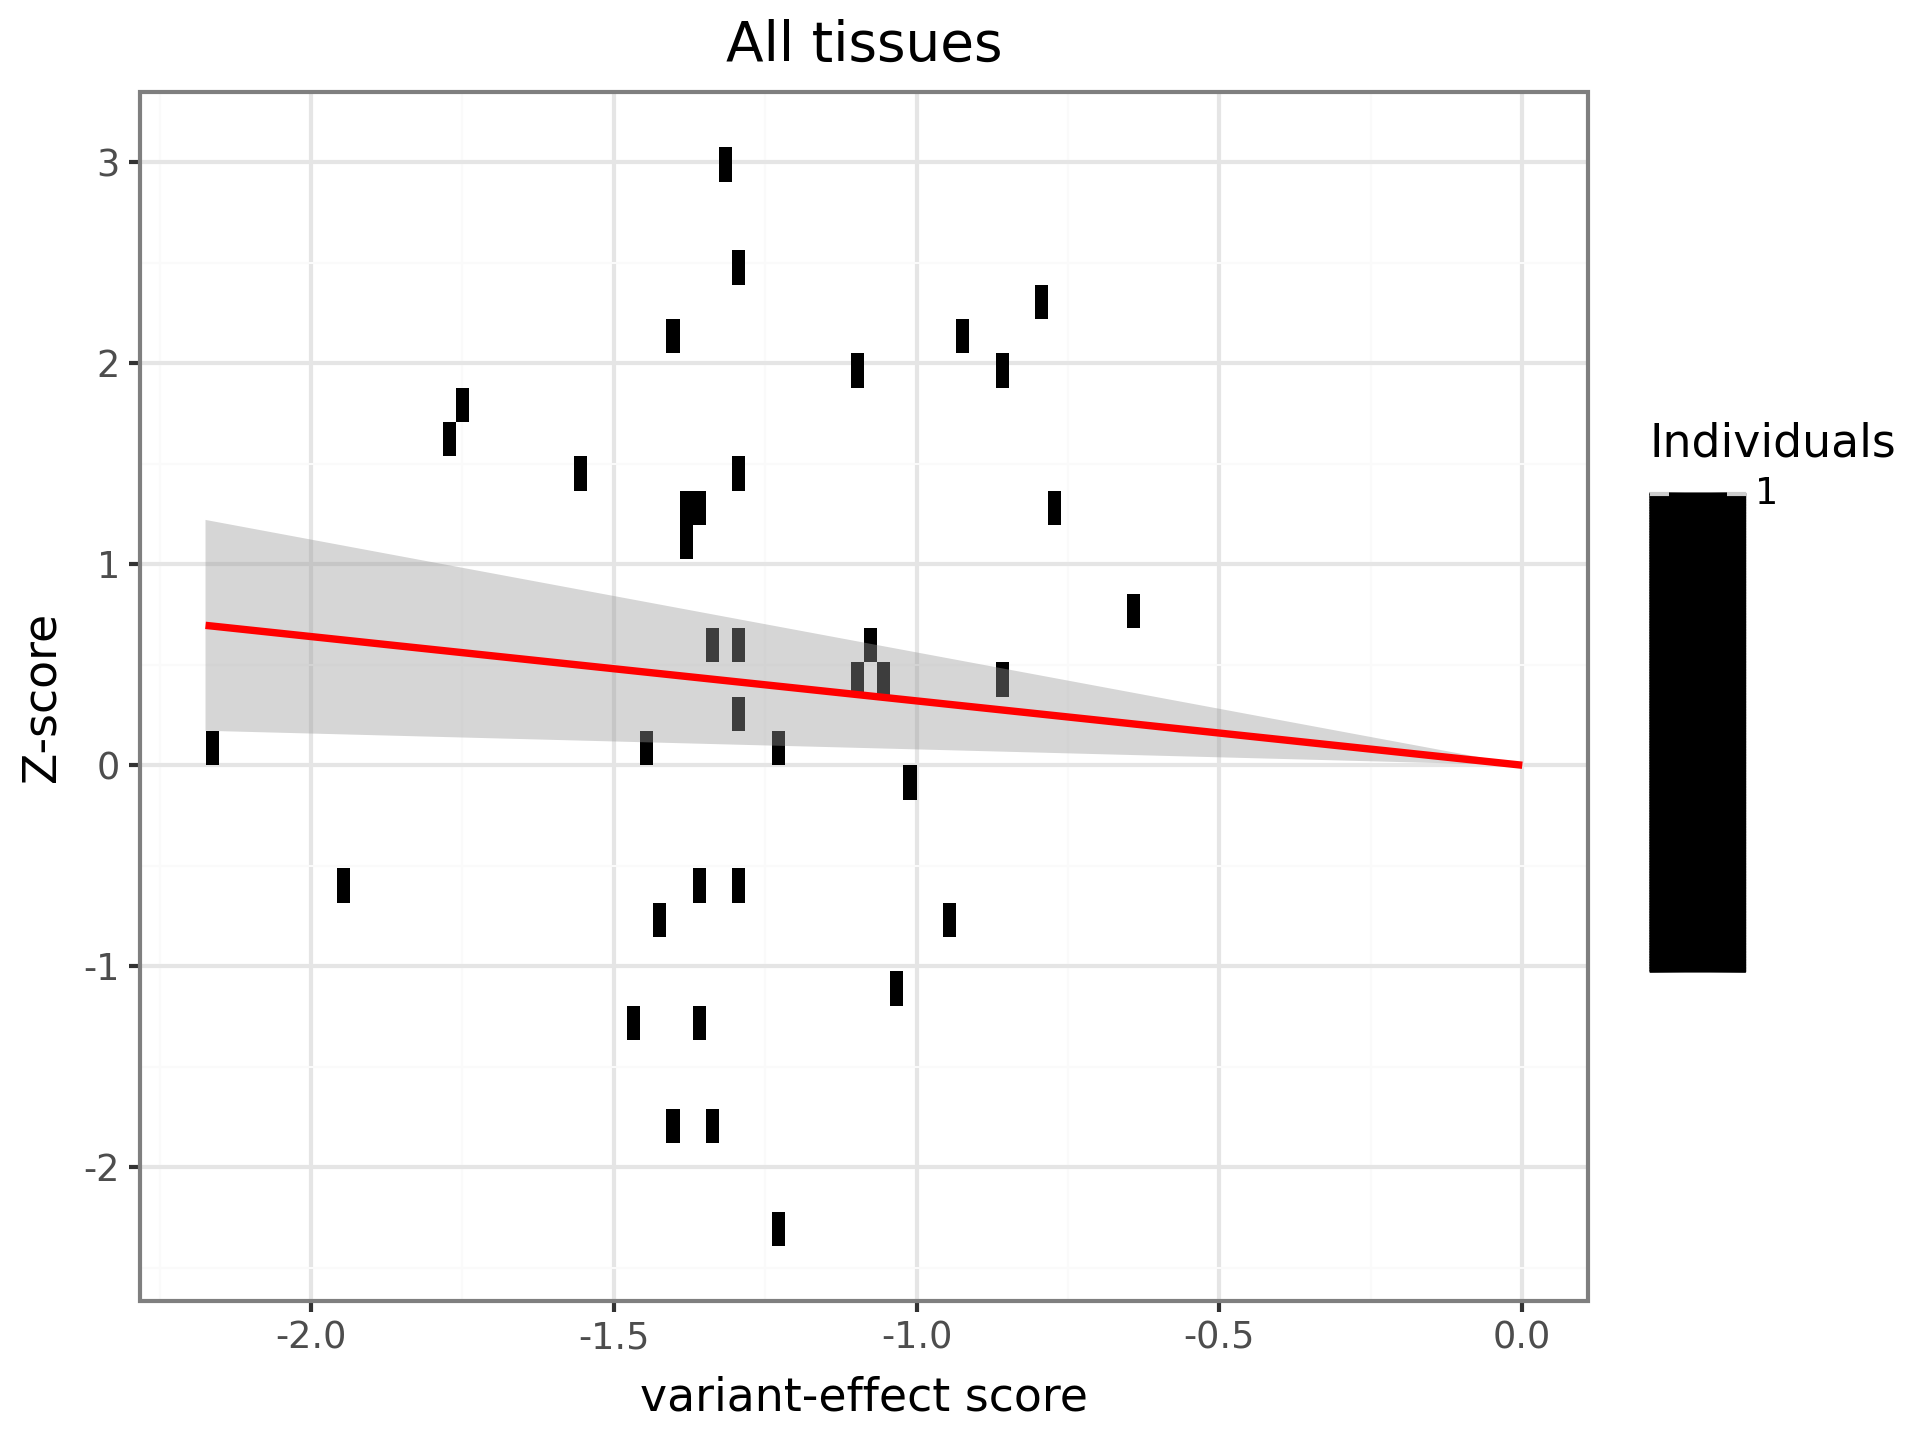

Traceback (most recent call last):
  File "/home/george/miniconda3/envs/kipoi-expression-prediction/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'weight'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_289963/1625643458.py", line 31, in <module>
    gg2.show()
  File "/home/george/miniconda3/envs/kipoi-expression-prediction/lib/python3.11/site-packages/plotnine/ggplot.py", line 150, in show
    self._display()

In [12]:
gg1 = (pn.ggplot(benchmark_df.select(pl.col(['zscore', 'veff_score'])), pn.aes(x='veff_score', y='zscore')) + 
 pn.geom_bin2d(bins=100) + 
 pn.geom_smooth(method="lm", color="red") +
 pn.scale_fill_gradient(name = "Individuals", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black") +
 pn.labs(
     x="variant-effect score", 
     y="Z-score",
     color="",
     fill="",
     title="All tissues",
 )
)

gg2 = (pn.ggplot(benchmark_df.select(pl.col(['zscore', 'veff_score', 'is_obvious_outlier'])), pn.aes(x='veff_score', y='zscore')) + 
 pn.facet_wrap('is_obvious_outlier', ncol=1, labeller='label_both') +
 pn.geom_bin2d(bins=100) + 
 pn.geom_smooth(method="lm", color="red") +
 pn.scale_fill_gradient(name = "Individuals", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black") +
 pn.labs(
     x="variant-effect score", 
     y="Z-score",
     color="",
     fill="",
     title="All tissues",
 )
)

if benchmark_df['veff_score'].unique().count() > 1:
    try:
        gg1.show()
        gg2.show()
    except Exception:
        traceback.print_exc()

In [13]:
# PR curve
total_prc_df = calc_prc_df(benchmark_df.select(pl.col(['y_true', 'y_pred'])).to_pandas(), true_col='y_true', pred_col='y_pred'). \
    assign(type_='total')
obvious_prc_df = calc_prc_df(benchmark_df.filter(pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred'])).to_pandas(), true_col='y_true', pred_col='y_pred'). \
    assign(type_='obvious')
notobvious_prc_df = calc_prc_df(benchmark_df.filter(~pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred'])).to_pandas(), true_col='y_true', pred_col='y_pred'). \
    assign(type_='not_obvious')
prc_df = pd.concat([total_prc_df, obvious_prc_df, notobvious_prc_df])

In [14]:
prc_df[['type_', 'auc']]

,type_,auc
0,total,0.000143
37,total,0.000143
0,obvious,0.051282
0,not_obvious,0.000106
37,not_obvious,0.000106


In [15]:
# save to parquet
prc_df.to_parquet(output["prc_path"], index=False)

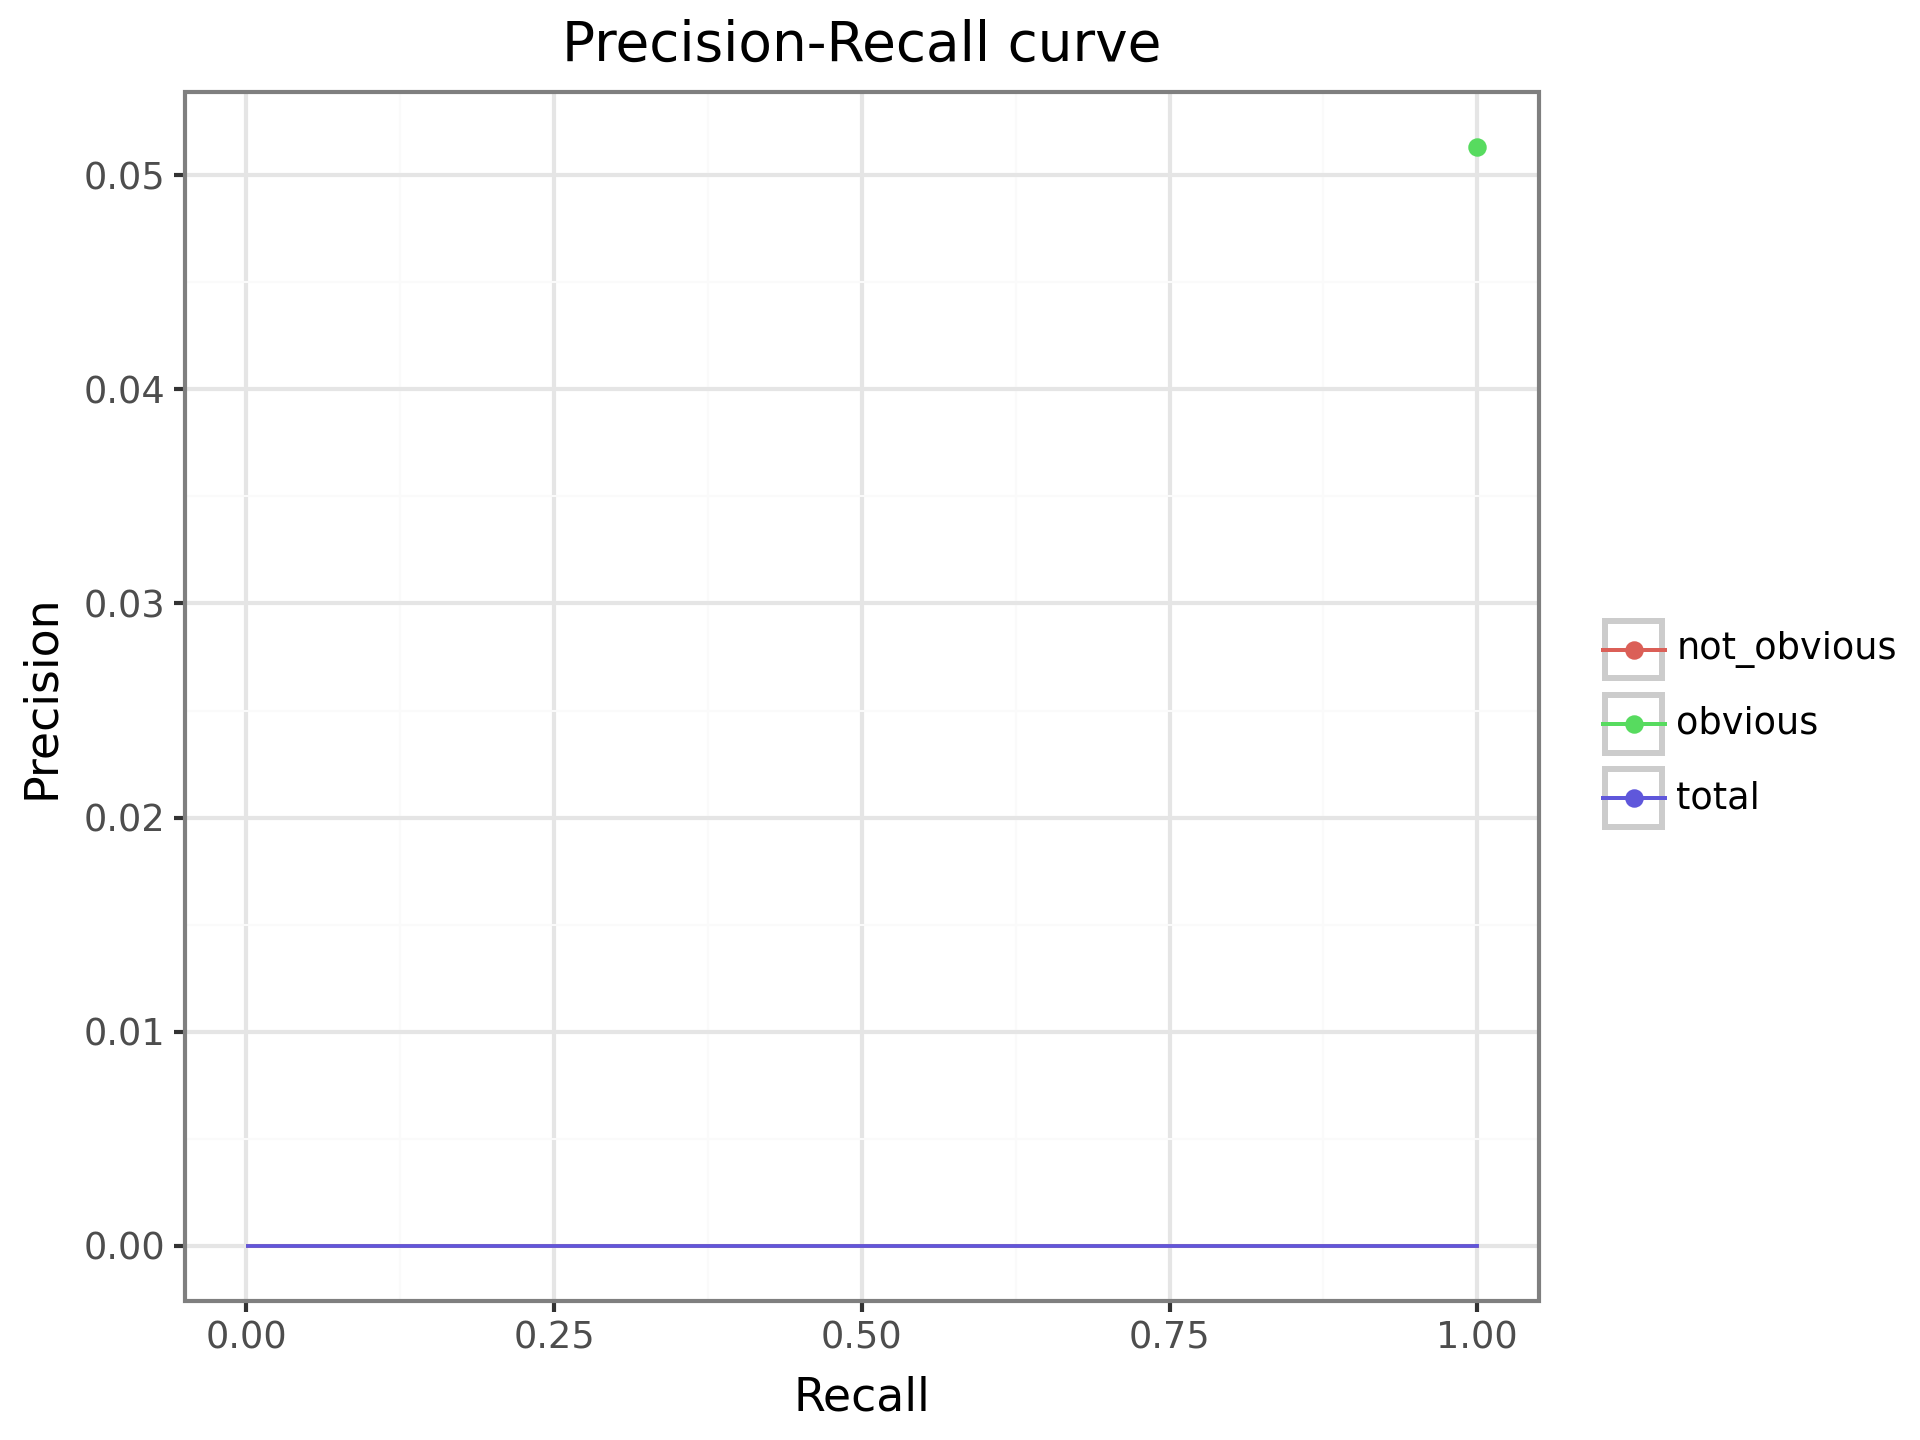

In [16]:
(pn.ggplot(prc_df, pn.aes(x='recall', y='precision', color='type_')) + 
 pn.geom_step(direction="hv") +
 pn.geom_point(data=prc_df.query("is_binary")) +
 pn.labs(
     x="Recall", 
     y="Precision",
     color="",
     fill="",
     title="Precision-Recall curve",
 )
)

### Across tissues

In [17]:
groupby='tissue'
r2_obv_tissue_df = benchmark_df.to_pandas().groupby([groupby, 'is_obvious_outlier'])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='obvious')
r2_obv_tissue_df.loc[~r2_obv_tissue_df.is_obvious_outlier, 'type_'] = 'not_obvious'
del r2_obv_tissue_df['is_obvious_outlier']
r2_tissue_df = benchmark_df.to_pandas().groupby([groupby])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='total')
r2_tissue_df = pd.concat([r2_tissue_df, r2_obv_tissue_df])

In [18]:
# save to parquet
r2_tissue_df.to_parquet(output["r2_tissue_path"], index=False)

In [19]:
r2_tissue_df

,tissue,r2,type_
0,Adipose - Subcutaneous,-0.000738,total
1,Adipose - Visceral (Omentum),-0.000625,total
2,Adrenal Gland,-0.010425,total
3,Artery - Aorta,-0.006663,total
4,Artery - Coronary,-0.005650,total
...,...,...,...
57,Uterus,-0.000716,not_obvious
58,Uterus,-0.047696,obvious
59,Vagina,-0.016100,not_obvious
60,Vagina,-0.085454,obvious


In [20]:
print('R2')
r2_tissue_df[["tissue","r2", "type_"]].drop_duplicates().groupby('type_')['r2'].apply(pretty_mean_confidence_interval)

R2


type_
not_obvious    -0.00275 +- 0.00161
obvious        -0.49388 +- 0.49160
total          -0.00274 +- 0.00161
Name: r2, dtype: object

In [21]:
# PR curve
groupby = 'tissue'
total_prc_df = calc_prc_df(benchmark_df.select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='total')
obvious_prc_df = calc_prc_df(benchmark_df.filter(pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='obvious')
notobvious_prc_df = calc_prc_df(benchmark_df.filter(~pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='not_obvious')

prc_df = pd.concat([total_prc_df, obvious_prc_df, notobvious_prc_df])

In [22]:
print('AUPRC')
prc_df[["tissue","auc", "type_"]].drop_duplicates().groupby('type_')['auc'].apply(pretty_mean_confidence_interval)

AUPRC


type_
not_obvious    0.00012 +- 0.00009
obvious        0.05710 +- 0.03030
total          0.00016 +- 0.00010
Name: auc, dtype: object

In [23]:
# save to parquet
prc_df.to_parquet(output["prc_tissue_path"], index=False)

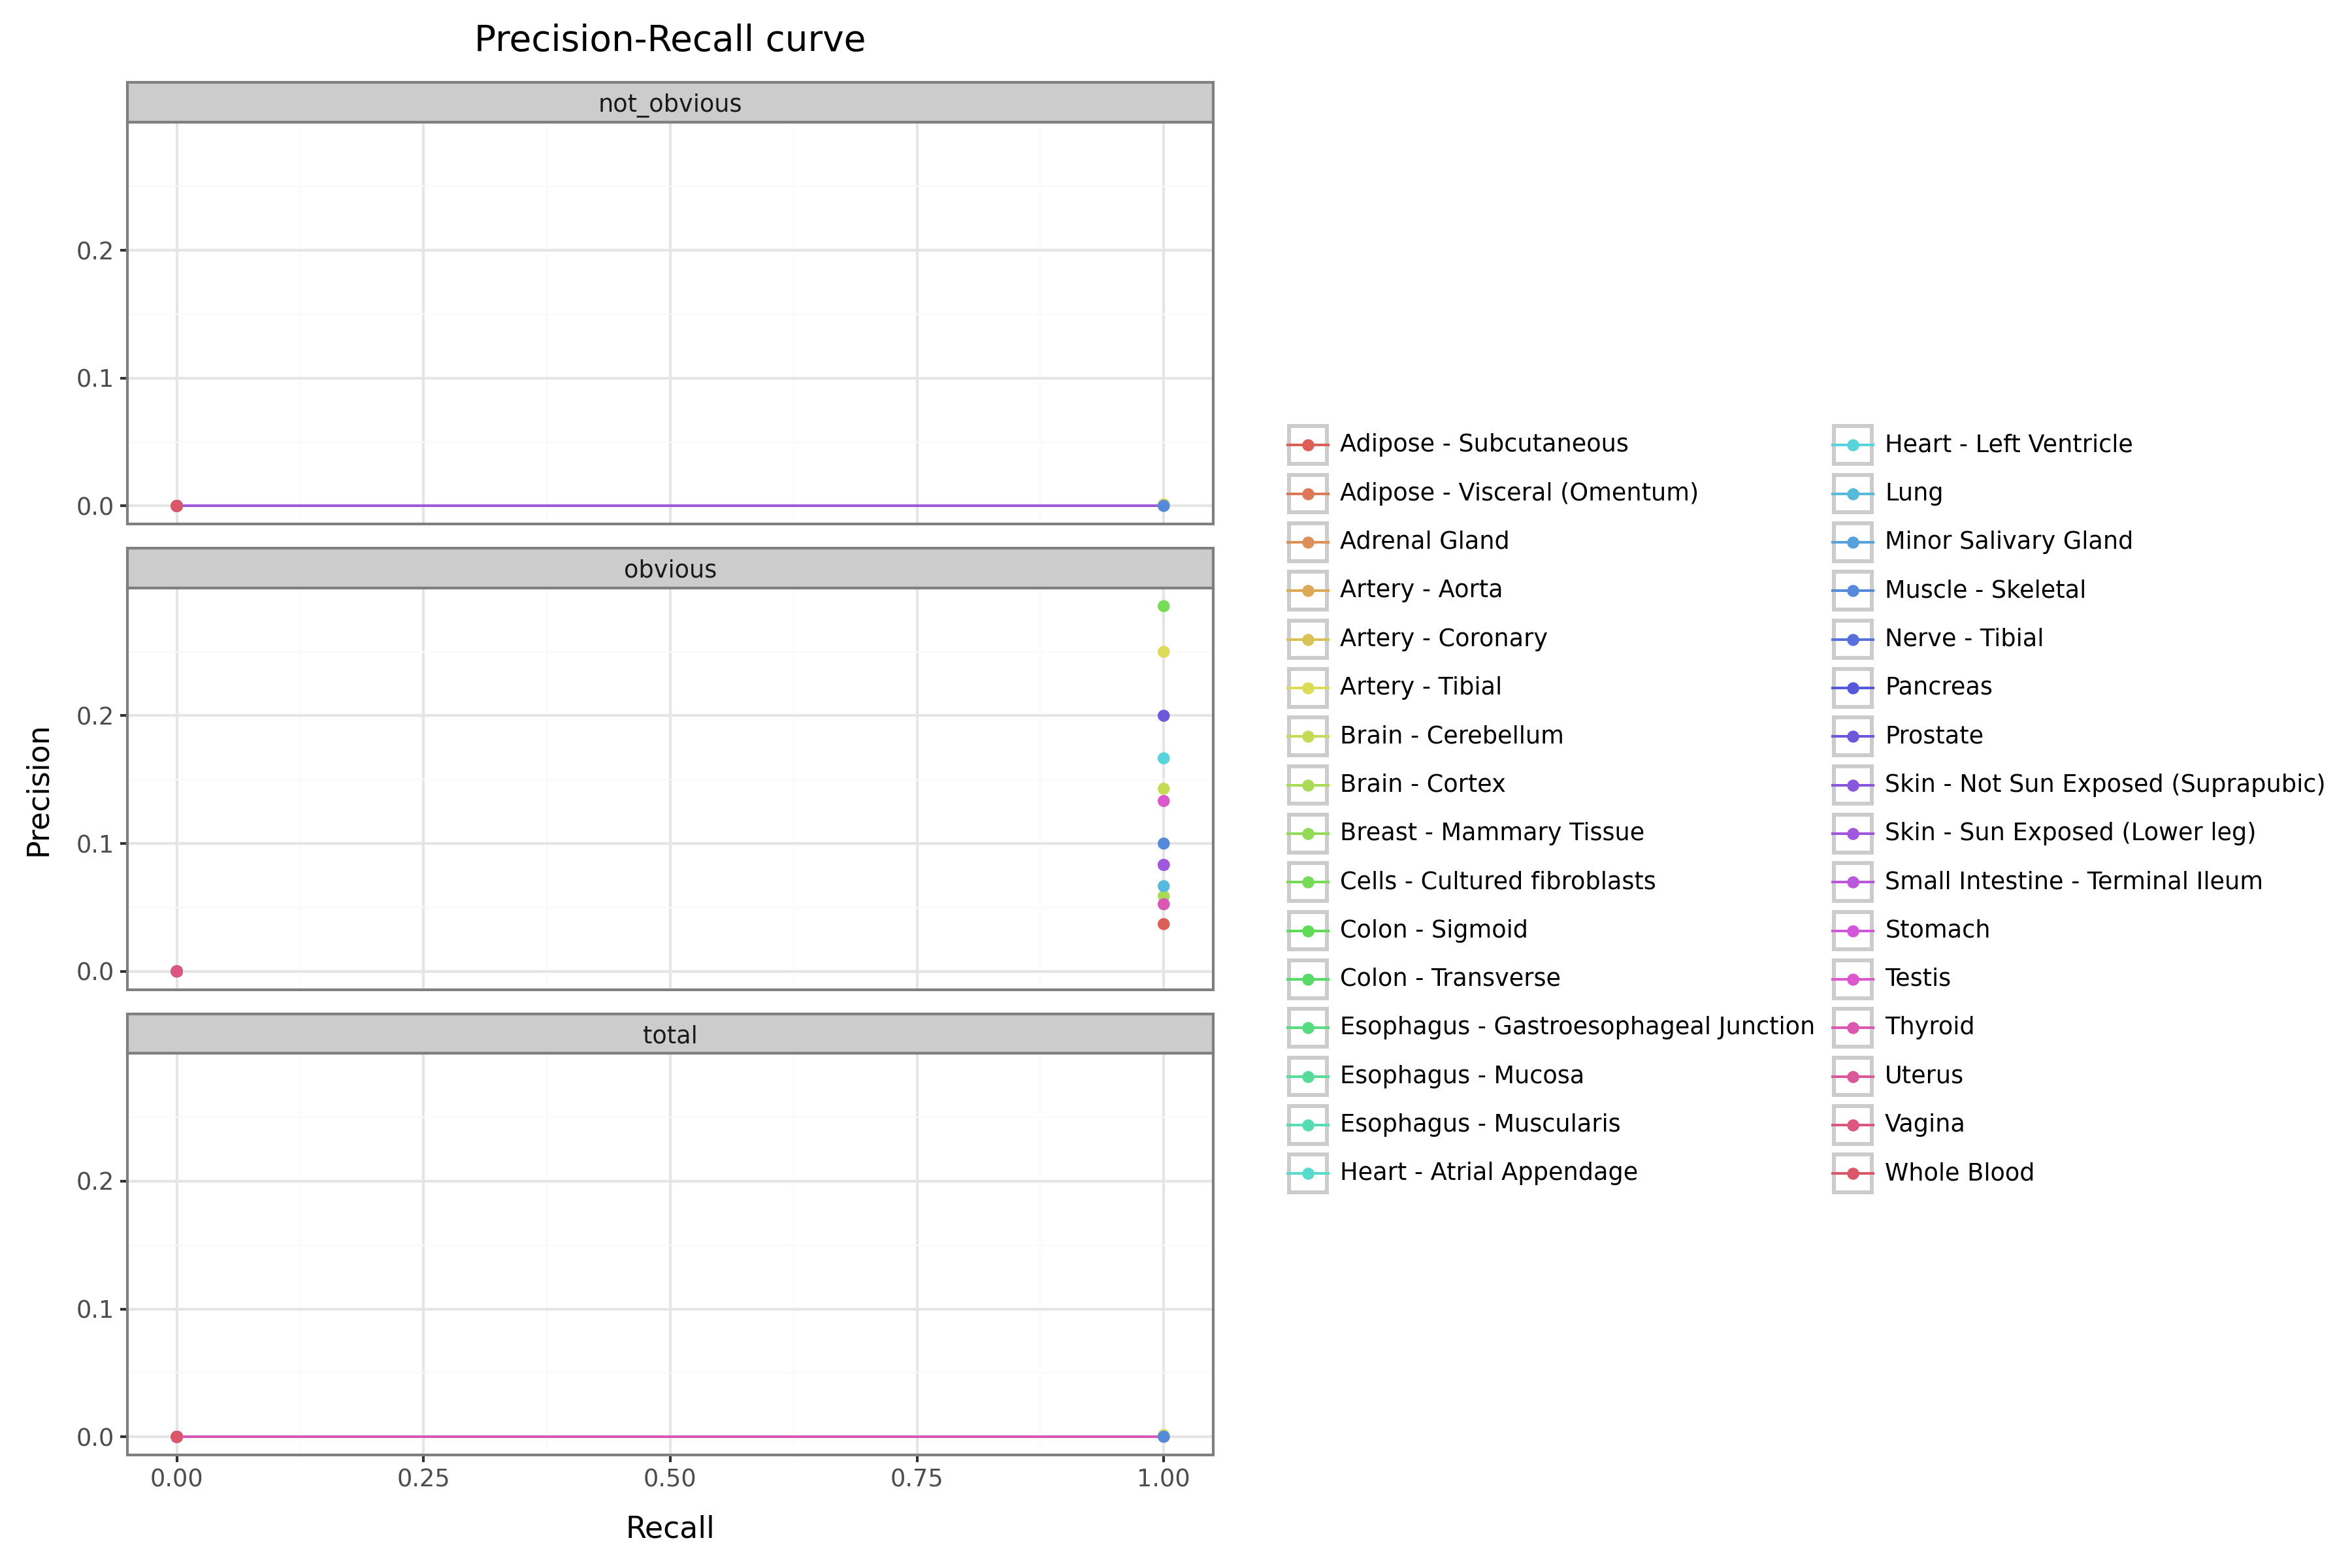

In [24]:
(pn.ggplot(prc_df, pn.aes(x='recall', y='precision', color=groupby, fill=groupby)) + 
 pn.facet_wrap('type_', ncol=1) +
 pn.geom_step(direction="hv") +
 pn.geom_point(data=prc_df.query("is_binary")) +
 pn.labs(
     x="Recall", 
     y="Precision",
     color="",
     fill="",
     title="Precision-Recall curve",
 ) +
 pn.theme(figure_size=(12,8))
)

### Across tissue type

In [25]:
groupby='tissue_type'
r2_obv_tissue_df = benchmark_df.to_pandas().groupby([groupby, 'is_obvious_outlier'])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='obvious')
r2_obv_tissue_df.loc[~r2_obv_tissue_df.is_obvious_outlier, 'type_'] = 'not_obvious'
del r2_obv_tissue_df['is_obvious_outlier']
r2_tissue_df = benchmark_df.to_pandas().groupby([groupby])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='total')
r2_tissue_df = pd.concat([r2_tissue_df, r2_obv_tissue_df])

In [26]:
# save to parquet
r2_tissue_df.to_parquet(output[f"r2_{groupby}_path"], index=False)

In [27]:
print('R2')
r2_tissue_df[[groupby, "r2", "type_"]].drop_duplicates().groupby('type_')['r2'].apply(pretty_mean_confidence_interval)

R2


type_
not_obvious    -0.00293 +- 0.00231
obvious        -0.61124 +- 0.71162
total          -0.00293 +- 0.00231
Name: r2, dtype: object

In [28]:
# PR curve
groupby = 'tissue_type'
total_prc_df = calc_prc_df(benchmark_df.select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='total')
obvious_prc_df = calc_prc_df(benchmark_df.filter(pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='obvious')
notobvious_prc_df = calc_prc_df(benchmark_df.filter(~pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='not_obvious')
prc_df = pd.concat([total_prc_df, obvious_prc_df, notobvious_prc_df])

In [29]:
def pretty_mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f'{m:.5f} +- {h:.5f}'

In [30]:
print('AUPRC')
prc_df[[groupby,"auc", "type_"]].drop_duplicates().groupby('type_')['auc'].apply(pretty_mean_confidence_interval)

AUPRC


type_
not_obvious    0.00012 +- 0.00008
obvious        0.04572 +- 0.02520
total          0.00015 +- 0.00008
Name: auc, dtype: object

In [31]:
# save to parquet
prc_df.to_parquet(output["prc_tissue_type_path"], index=False)

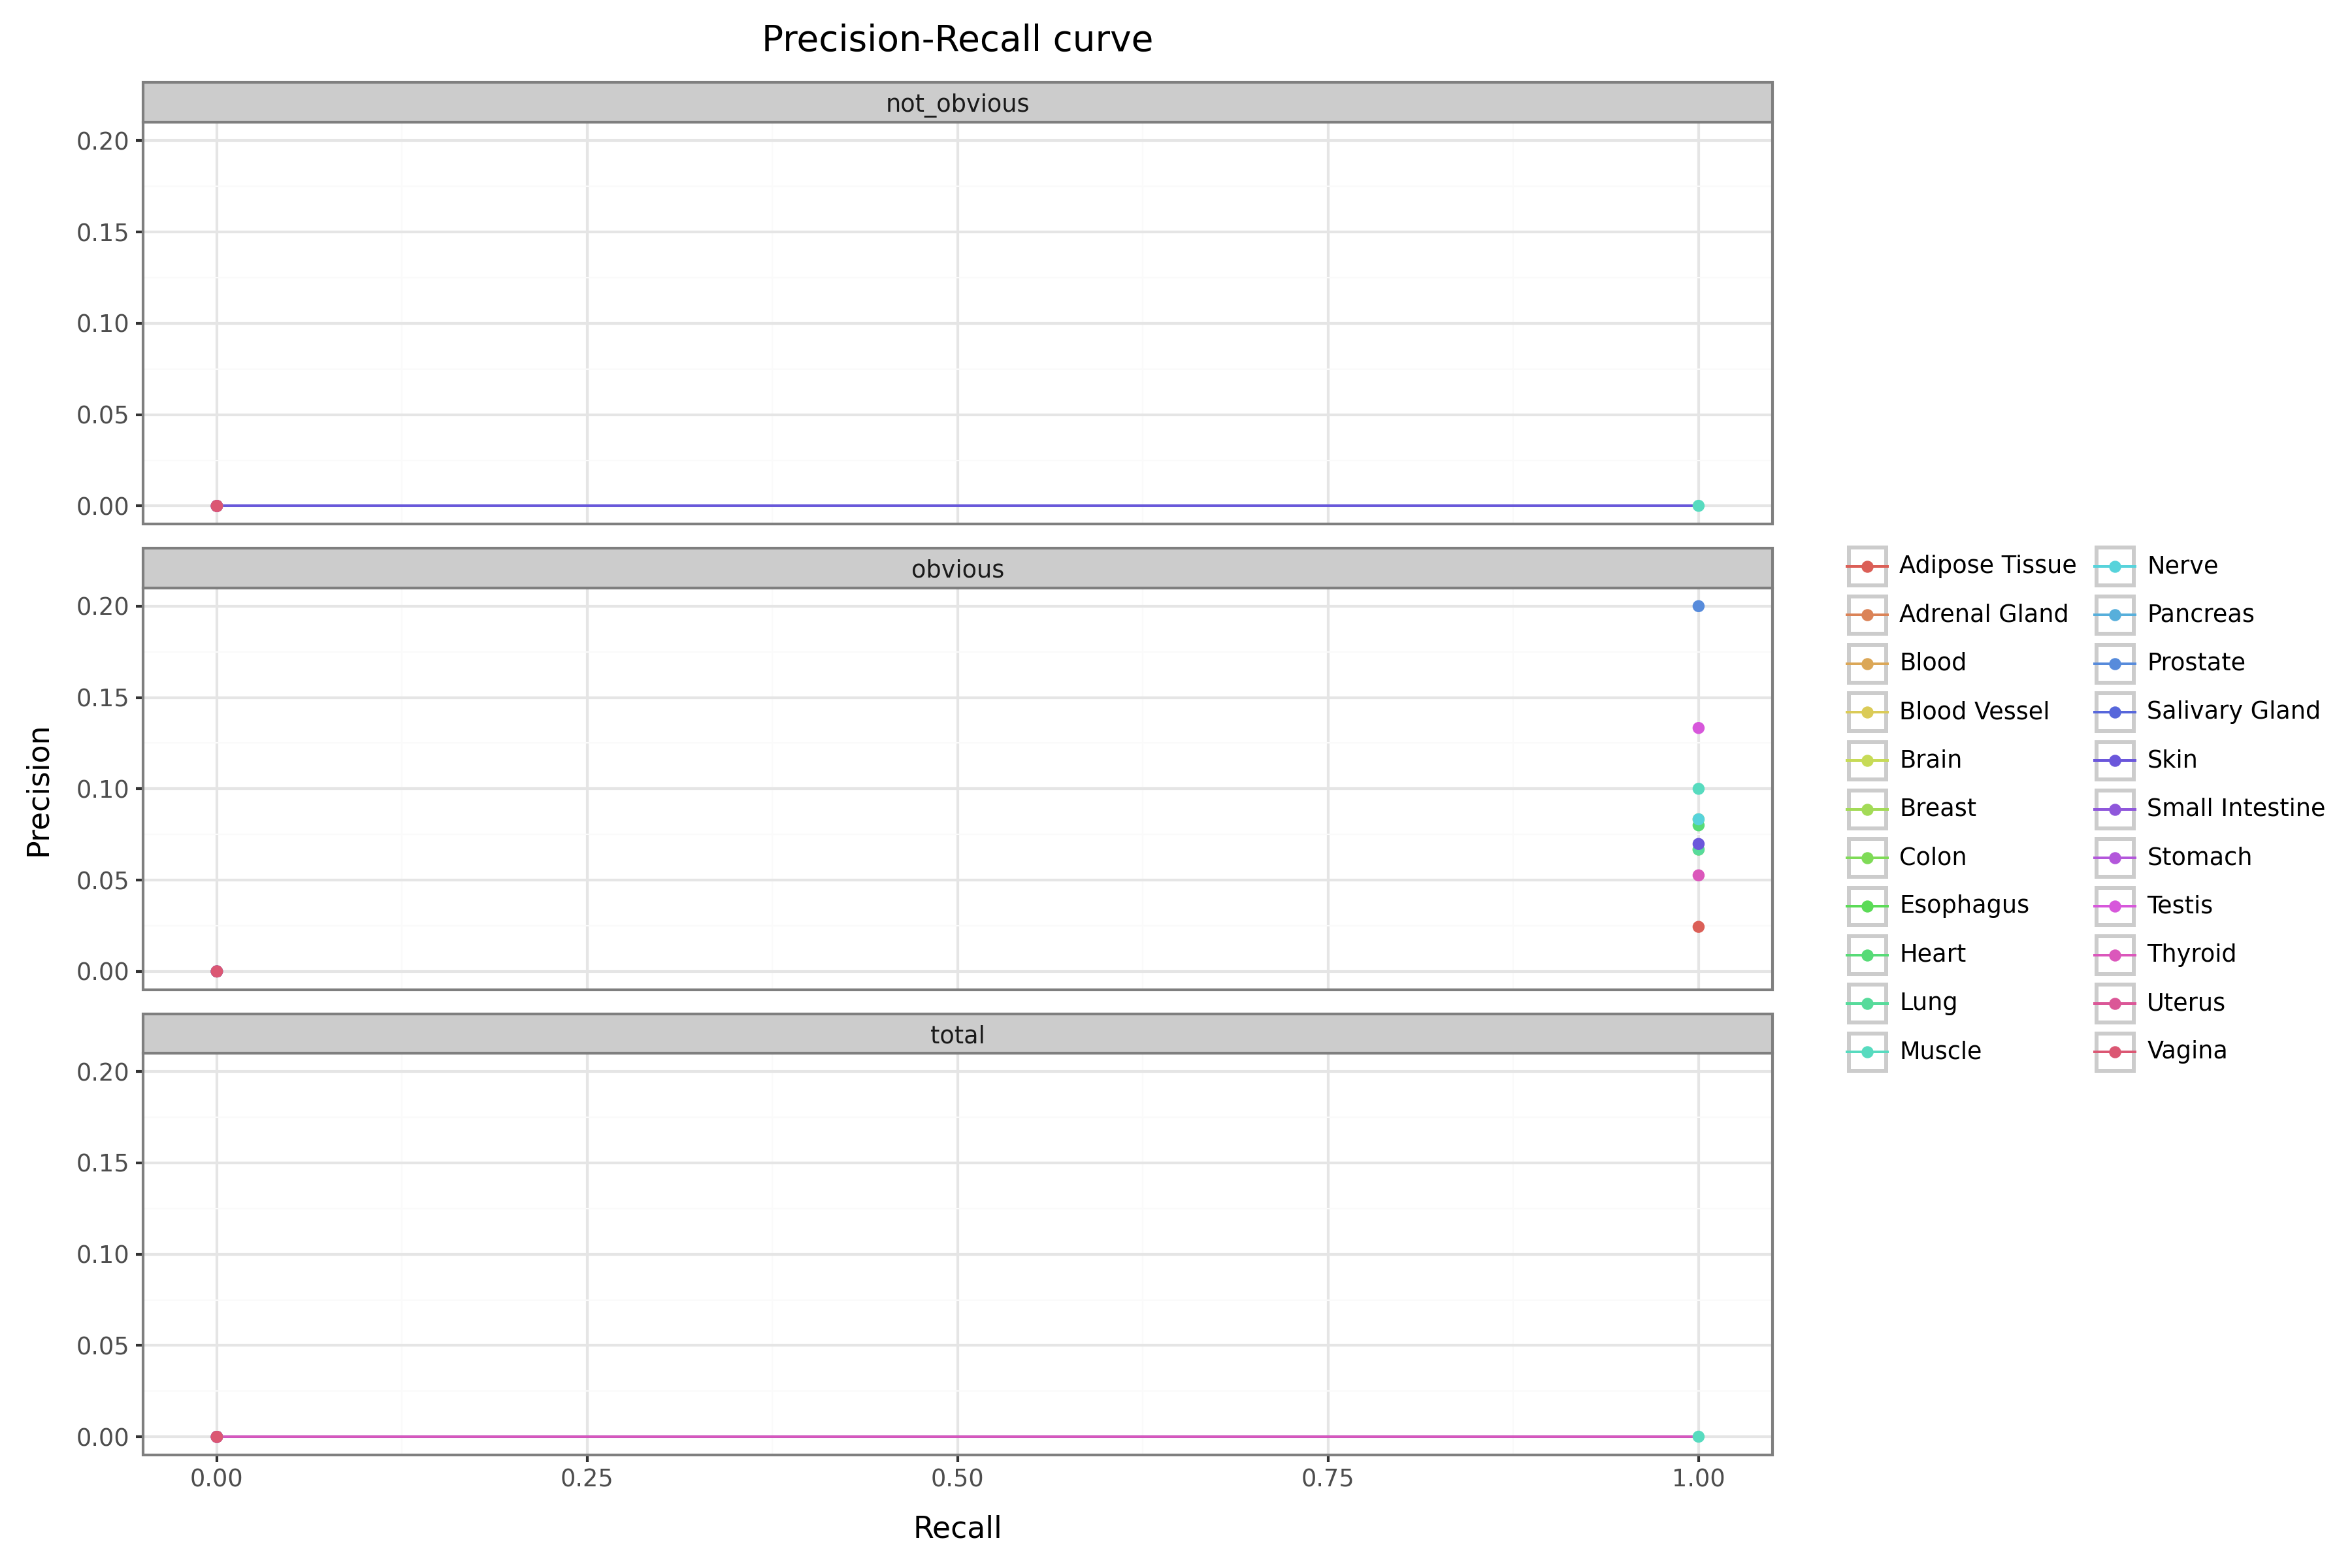

In [32]:
(pn.ggplot(prc_df.sort_values('auc'), pn.aes(x='recall', y='precision', color=groupby, fill=groupby)) + 
 pn.facet_wrap('type_', ncol=1) +
 pn.geom_step(direction="hv") +
 pn.geom_point(data=prc_df.query("is_binary")) +
 pn.labs(
     x="Recall", 
     y="Precision",
     color="",
     fill="",
     title="Precision-Recall curve",
 ) +
 pn.theme(figure_size=(12,8))
)

### Across folds

In [33]:
groupby='fold'
r2_obv_tissue_df = benchmark_df.to_pandas().groupby([groupby, 'is_obvious_outlier'])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='obvious')
r2_obv_tissue_df.loc[~r2_obv_tissue_df.is_obvious_outlier, 'type_'] = 'not_obvious'
del r2_obv_tissue_df['is_obvious_outlier']
r2_tissue_df = benchmark_df.to_pandas().groupby([groupby])[['zscore', 'veff_score']]. \
    apply(lambda x: r2_score(x['zscore'], x['veff_score'])).reset_index(name='r2').assign(type_='total')
r2_tissue_df = pd.concat([r2_tissue_df, r2_obv_tissue_df])

In [34]:
# save to parquet
r2_tissue_df.to_parquet(output[f"r2_{groupby}_path"], index=False)

In [35]:
print('R2')
r2_tissue_df[[groupby, "r2", "type_"]].drop_duplicates().groupby('type_')['r2'].apply(pretty_mean_confidence_interval)

R2


type_
not_obvious    -0.00026 +- 0.00027
obvious        -0.12558 +- 0.13650
total          -0.00026 +- 0.00026
Name: r2, dtype: object

In [36]:
# PR curve
groupby = 'fold'
total_prc_df = calc_prc_df(benchmark_df.select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='total')
obvious_prc_df = calc_prc_df(benchmark_df.filter(pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='obvious')
notobvious_prc_df = calc_prc_df(benchmark_df.filter(~pl.col('is_obvious_outlier')).select(pl.col(['y_true', 'y_pred', groupby])).to_pandas(), true_col='y_true', pred_col='y_pred',  groupby=groupby). \
    assign(type_='not_obvious')
prc_df = pd.concat([total_prc_df, obvious_prc_df, notobvious_prc_df])

In [37]:
def pretty_mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f'{m:.5f} +- {h:.5f}'

In [38]:
print('AUPRC')
prc_df[[groupby,"auc", "type_"]].drop_duplicates().groupby('type_')['auc'].apply(pretty_mean_confidence_interval)

AUPRC


type_
not_obvious    0.00011 +- 0.00005
obvious        0.05068 +- 0.04489
total          0.00014 +- 0.00007
Name: auc, dtype: object

In [39]:
# save to parquet
prc_df.to_parquet(output["prc_fold_path"], index=False)

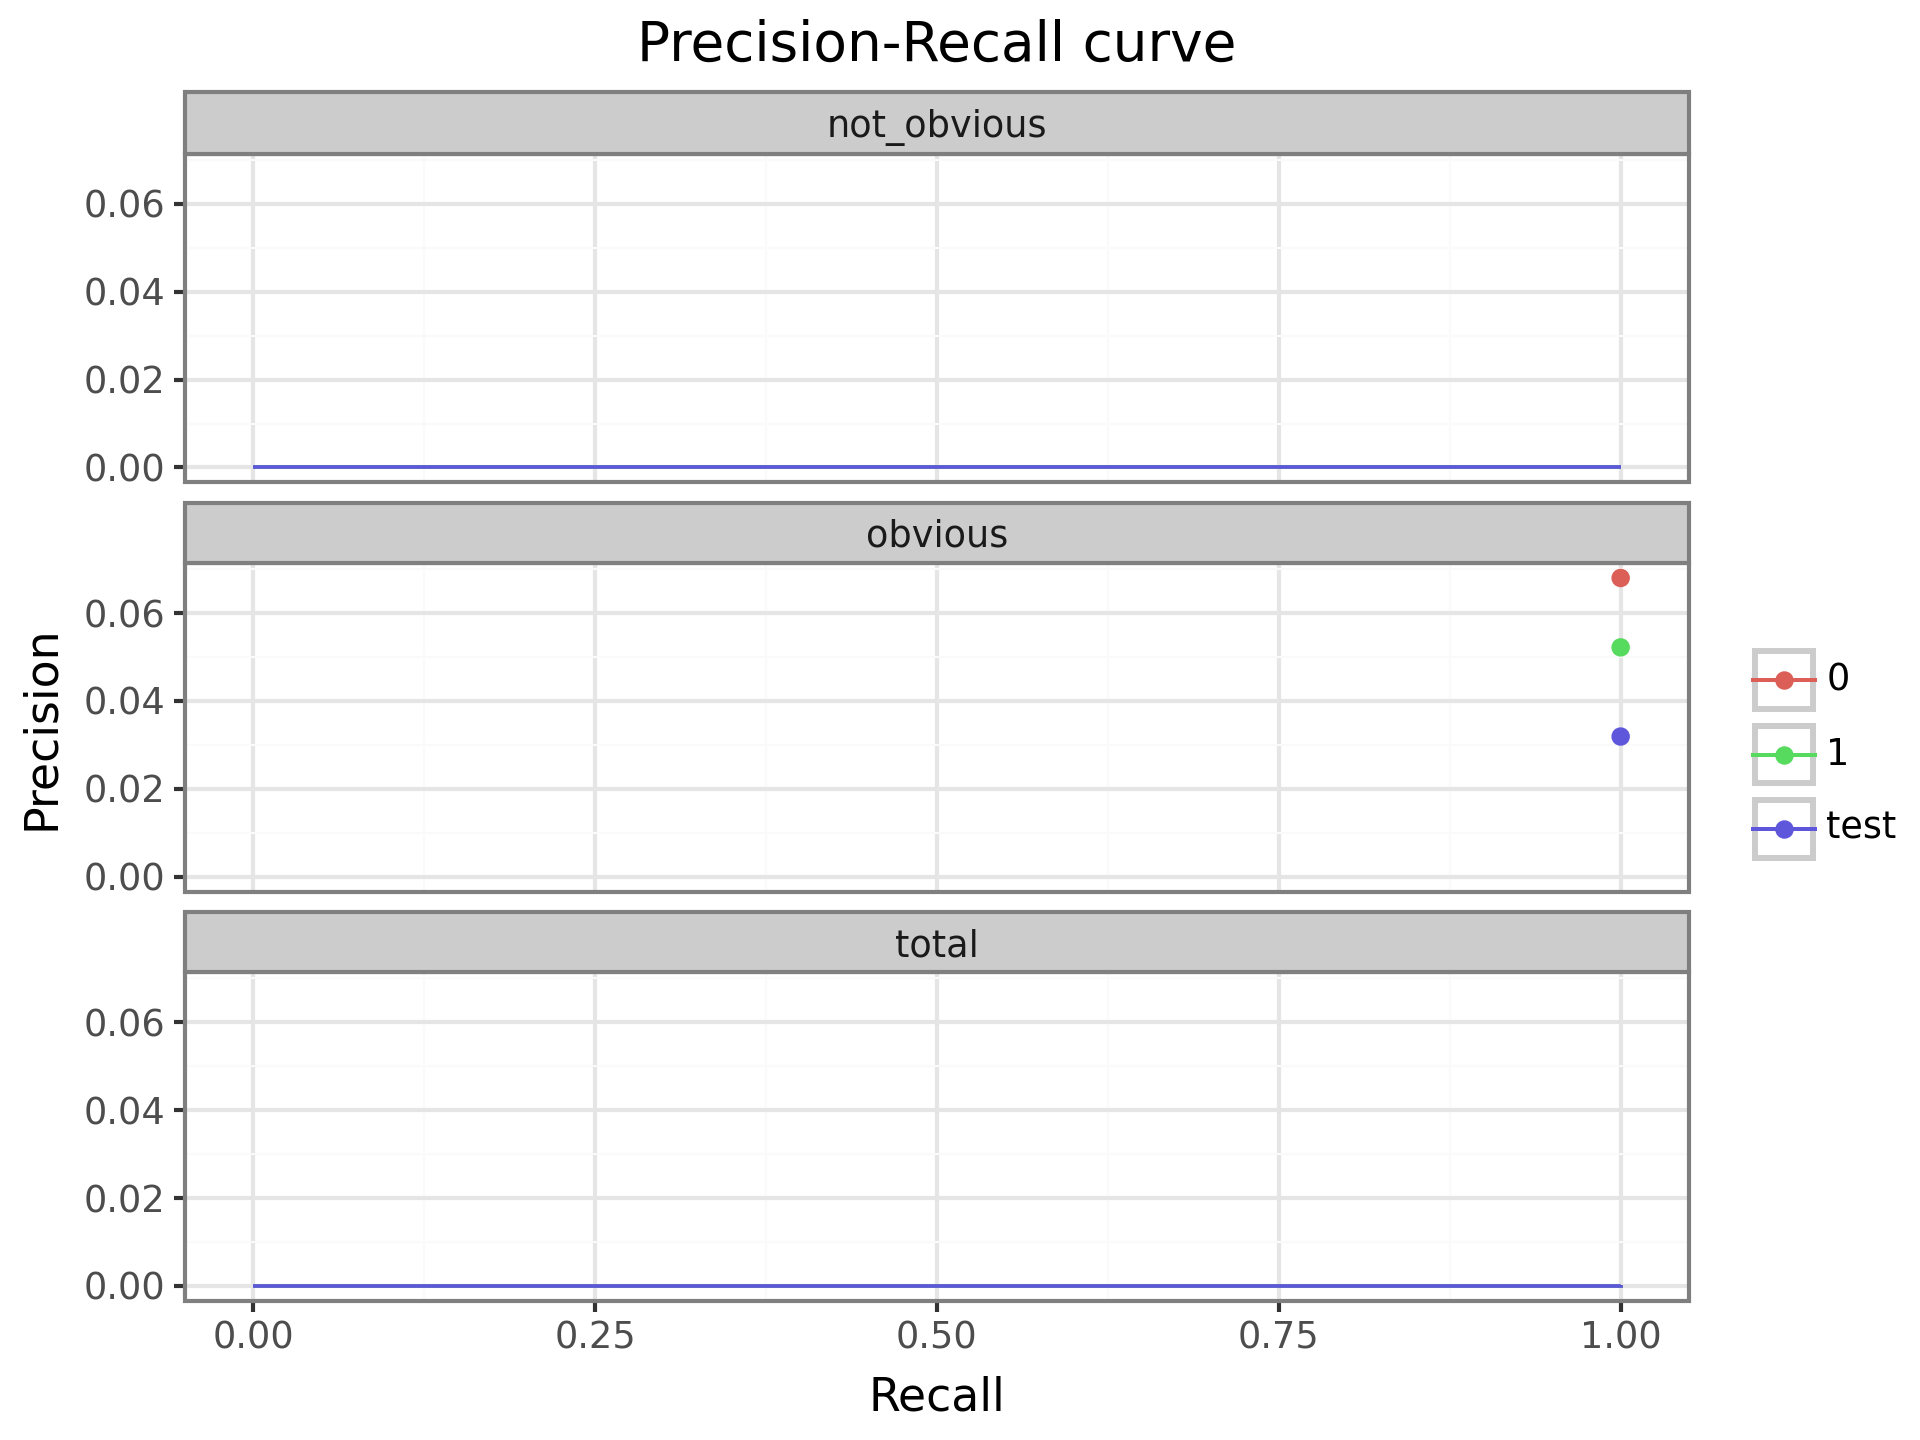

In [40]:
(pn.ggplot(prc_df, pn.aes(x='recall', y='precision', color=groupby, fill=groupby)) + 
 pn.facet_wrap('type_', ncol=1) +
 pn.geom_step(direction="hv") +
 pn.geom_point(data=prc_df.query("is_binary")) +
 pn.labs(
     x="Recall", 
     y="Precision",
     color="",
     fill="",
     title="Precision-Recall curve",
 )
)